In [1]:
import pandas as pd
import os
import re
from tqdm.notebook import tqdm
import gcsfs
from google.auth import default

# --- Célula 1: Configuração e Autenticação Local ---

# NOTA IMPORTANTE: Certifique-se de que a conta autenticada via 'gcloud'
# é a mesma conta do Google que tem permissão para acessar o bucket do GCS.
print("Tentando autenticar-se com as credenciais locais do gcloud...")
try:
    credentials, project = default()
    gcs = gcsfs.GCSFileSystem(project=project, token=credentials) 
    print("Autenticação bem-sucedida!")
except Exception as e:
    print(f"Falha na autenticação: {e}")
    print("Certifique-se de que você executou 'gcloud auth application-default login' no seu terminal.")


# --- Configuração do GCS ---
BUCKET_NAME = 'datathon-decision-ai-bolanos' 
print("Configuração lista.")

Tentando autenticar-se com as credenciais locais do gcloud...
Autenticação bem-sucedida!
Configuração lista.


In [2]:
# --- Célula 2: Carregamento dos Dados do GCS ---

try:
    print("Carregando applicants.json... (Pode demorar)")
    applicants_path = f"gs://{BUCKET_NAME}/data/applicants.json"
    df_applicants = pd.read_json(applicants_path, orient='index')
    print(f"-> Carregado com sucesso. Dimensões: {df_applicants.shape}")

    print("\nCarregando vagas.json...")
    vagas_path = f"gs://{BUCKET_NAME}/data/vagas.json"
    df_vagas = pd.read_json(vagas_path, orient='index')
    print(f"-> Carregado com sucesso. Dimensões: {df_vagas.shape}")

    print("\nCarregando prospects.json...")
    prospects_path = f"gs://{BUCKET_NAME}/data/prospects.json"
    df_prospects = pd.read_json(prospects_path, orient='index')
    print(f"-> Carregado com sucesso. Dimensões: {df_prospects.shape}")

except Exception as e:
    print(f"Erro ao carregar dados do GCS: {e}")
    print("Verifique se o nome do bucket está correto e se você tem conexão com a internet.")

Carregando applicants.json... (Pode demorar)
-> Carregado com sucesso. Dimensões: (42482, 7)

Carregando vagas.json...
-> Carregado com sucesso. Dimensões: (14081, 3)

Carregando prospects.json...
-> Carregado com sucesso. Dimensões: (14222, 3)


In [9]:
# --- Célula 3: Aplanamento de VAGAS (con columna 'vaga_id' explícita) ---

print("Aplanando df_vagas...")

vagas_flat_parts = [pd.json_normalize(df_vagas[col]) for col in ['informacoes_basicas', 'perfil_vaga', 'beneficios']]
df_vagas_flat = pd.concat(vagas_flat_parts, axis=1)

# ✅ Agregar columna 'vaga_id' explícita (antes era solo el índice)
df_vagas_flat['vaga_id'] = df_vagas.index  # <-- ¡Clave para unir!

# ✅ Mover 'vaga_id' a la primera columna
cols = ['vaga_id'] + [col for col in df_vagas_flat.columns if col != 'vaga_id']
df_vagas_flat = df_vagas_flat[cols]

print(f"-> df_vagas_flat criado com sucesso. Dimensões: {df_vagas_flat.shape}")

print("\n--- Amostra do DataFrame de Vagas Aplanado (com vaga_id) ---")
display(df_vagas_flat[['vaga_id', 'cliente', 'nome']].head())

Aplanando df_vagas...
-> df_vagas_flat criado com sucesso. Dimensões: (14081, 45)

--- Amostra do DataFrame de Vagas Aplanado (com vaga_id) ---


,vaga_id,cliente,nome
0,5185,"Morris, Moran and Dodson",
1,5184,"Morris, Moran and Dodson",
2,5183,"Morris, Moran and Dodson",
3,5182,Nelson-Page,NaN
4,5181,Mann and Sons,


In [8]:
# --- Célula 4: Aplanamento de PROSPECTS (RENOMBRADO para consistencia) ---

print("Aplanando df_prospects...")

prospects_list = []

for vaga_id, row in df_prospects.iterrows():
    for prospect in row['prospects']:
        record = {
            'vaga_id': vaga_id,           # ID de la vaga
            'titulo_vaga': row['titulo'],
            'modalidade': row['modalidade'],
            **prospect                   # Incluye 'nome', 'codigo', etc.
        }
        prospects_list.append(record)

df_prospects_flat = pd.DataFrame(prospects_list)

# ✅ RENOMBRAR 'codigo' → 'codigo_profissional' para consistencia con applicants
df_prospects_flat.rename(columns={'codigo': 'codigo_profissional'}, inplace=True)

# ✅ Asegurar que sea string (para unir correctamente)
df_prospects_flat['codigo_profissional'] = df_prospects_flat['codigo_profissional'].astype(str)

print(f"-> df_prospects_flat criado com sucesso. Dimensões: {df_prospects_flat.shape}")

print("\n--- Amostra do DataFrame de Prospects Aplanado (CONSISTENTE) ---")
display(df_prospects_flat[['nome', 'codigo_profissional', 'vaga_id', 'situacao_candidado']].head())

Aplanando df_prospects...
-> df_prospects_flat criado com sucesso. Dimensões: (53759, 10)

--- Amostra do DataFrame de Prospects Aplanado (CONSISTENTE) ---


,nome,codigo_profissional,vaga_id,situacao_candidado
0,José Vieira,25632,4530,Encaminhado ao Requisitante
1,Srta. Isabela Cavalcante,25529,4530,Encaminhado ao Requisitante
2,Sra. Yasmin Fernandes,25364,4531,Contratado pela Decision
3,Alexia Barbosa,25360,4531,Encaminhado ao Requisitante
4,Arthur Almeida,26338,4533,Contratado pela Decision


In [7]:
# --- Célula 5: Aplanamento LIMPIO y OPTIMIZADO de APPLICANTS ---

print("Aplanando df_applicants...")

# Aplanar cada sección con prefijos
df_basicas = pd.json_normalize(df_applicants['infos_basicas']).add_prefix('basicas_')
df_pessoais = pd.json_normalize(df_applicants['informacoes_pessoais']).add_prefix('pessoais_')
df_profissionais = pd.json_normalize(df_applicants['informacoes_profissionais']).add_prefix('profissionais_')
df_formacao = pd.json_normalize(df_applicants['formacao_e_idiomas']).add_prefix('formacao_')
df_cargo_atual = pd.json_normalize(df_applicants['cargo_atual']).add_prefix('cargo_atual_')

# Columnas simples
df_simple = df_applicants[['cv_pt', 'cv_en']].reset_index(drop=True)

# Concatenar TODO
df_applicants_flat = pd.concat([
    df_basicas,
    df_pessoais,
    df_profissionais,
    df_formacao,
    df_cargo_atual,
    df_simple
], axis=1)

# ✅ PASO 1: Definir columna clave 'codigo_profissional'
if 'basicas_codigo_profissional' in df_applicants_flat.columns:
    df_applicants_flat['codigo_profissional'] = df_applicants_flat['basicas_codigo_profissional'].astype(str)
else:
    df_applicants_flat['codigo_profissional'] = df_applicants.index.astype(str)

# ✅ PASO 2: Eliminar redundancias y renombrar campos clave

# Si basicas_nome y pessoais_nome existen y son iguales → quedarse con basicas_nome como 'nome'
if 'basicas_nome' in df_applicants_flat.columns and 'pessoais_nome' in df_applicants_flat.columns:
    # Opcional: Verificar si son iguales (puedes saltar esto si confías en los datos)
    # iguales = (df_applicants_flat['basicas_nome'] == df_applicants_flat['pessoais_nome']).all()
    # print(f"Todos los nombres básicos y personales coinciden: {iguales}")
    df_applicants_flat.drop(columns=['pessoais_nome'], inplace=True)
    df_applicants_flat.rename(columns={'basicas_nome': 'nome'}, inplace=True)
elif 'basicas_nome' in df_applicants_flat.columns:
    df_applicants_flat.rename(columns={'basicas_nome': 'nome'}, inplace=True)
elif 'pessoais_nome' in df_applicants_flat.columns:
    df_applicants_flat.rename(columns={'pessoais_nome': 'nome'}, inplace=True)

# Igual para email
if 'basicas_email' in df_applicants_flat.columns and 'pessoais_email' in df_applicants_flat.columns:
    df_applicants_flat.drop(columns=['pessoais_email'], inplace=True)
    df_applicants_flat.rename(columns={'basicas_email': 'email'}, inplace=True)
elif 'basicas_email' in df_applicants_flat.columns:
    df_applicants_flat.rename(columns={'basicas_email': 'email'}, inplace=True)
elif 'pessoais_email' in df_applicants_flat.columns:
    df_applicants_flat.rename(columns={'pessoais_email': 'email'}, inplace=True)

# Renombrar teléfono principal (si existe)
if 'basicas_telefone' in df_applicants_flat.columns:
    df_applicants_flat.rename(columns={'basicas_telefone': 'telefone'}, inplace=True)
elif 'pessoais_telefone_celular' in df_applicants_flat.columns:
    df_applicants_flat.rename(columns={'pessoais_telefone_celular': 'telefone'}, inplace=True)

# ✅ PASO 3: Eliminar prefijos innecesarios en otras columnas (opcional, para limpieza visual)
# Vamos a quitar prefijos de algunas secciones si no hay conflicto
# Ejemplo: 'formacao_nivel_academico' → 'nivel_academico'
for col in df_applicants_flat.columns:
    if col.startswith('formacao_') and not col.replace('formacao_', '') in df_applicants_flat.columns:
        df_applicants_flat.rename(columns={col: col.replace('formacao_', '')}, inplace=True)
    if col.startswith('profissionais_') and not col.replace('profissionais_', '') in df_applicants_flat.columns:
        df_applicants_flat.rename(columns={col: col.replace('profissionais_', '')}, inplace=True)
    if col.startswith('pessoais_') and not col.replace('pessoais_', '') in df_applicants_flat.columns:
        df_applicants_flat.rename(columns={col: col.replace('pessoais_', '')}, inplace=True)

print(f"-> df_applicants_flat criado com sucesso. Dimensões: {df_applicants_flat.shape}")

# ✅ Mostrar una muestra con columnas relevantes (no solo 6)
print("\n--- Amostra do DataFrame de Applicants Aplanado (LIMPIO) ---")
cols_relevantes = [
    'nome', 'email', 'telefone', 'codigo_profissional',
    'nivel_academico', 'nivel_ingles', 'titulo_profissional',
    'area_atuacao', 'remuneracao', 'cv_pt'
]
# Filtrar solo columnas que existan
cols_relevantes = [col for col in cols_relevantes if col in df_applicants_flat.columns]
display(df_applicants_flat[cols_relevantes].head())

Aplanando df_applicants...
-> df_applicants_flat criado com sucesso. Dimensões: (42482, 56)

--- Amostra do DataFrame de Applicants Aplanado (LIMPIO) ---


,nome,email,telefone,codigo_profissional,nivel_academico,nivel_ingles,titulo_profissional,area_atuacao,remuneracao,cv_pt
0,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,31000,,,,,,assistente administrativo\n\n\nsantosbatista\n...
1,Eduardo Rios,eduardo_rios@hotmail.com,(11) 93723-4396,31001,Ensino Superior Incompleto,Nenhum,Analista Administrativo,Administrativa,1900,formação acadêmica\nensino médio (2º grau) em ...
2,Pedro Henrique Carvalho,pedro_henrique_carvalho@gmail.com,(11) 92399-9824,31002,Ensino Superior Completo,Intermediário,Administrativo | Financeiro,Administrativa,"2.500,00",objetivo: área administrativa | financeira\n\n...
3,Thiago Barbosa,thiago_barbosa@hotmail.com,(11) 98100-1727,31003,Ensino Superior Incompleto,Nenhum,Área administrativa,Administrativa,"1100,00",formação\nensino médio completo\ninformática i...
4,Diogo das Neves,diogo_das_neves@hotmail.com,(11) 92517-2678,31004,,,,,,última atualização em 09/11/2021\n­ sp\n\nensi...


In [10]:
print("Verificando consistencia de nombres de columnas clave:")

print("\nColumnas clave en applicants_flat:")
print([col for col in df_applicants_flat.columns if 'codigo' in col or 'profissional' in col])

print("\nColumnas clave en prospects_flat:")
print(df_prospects_flat.columns[df_prospects_flat.columns.isin(['codigo_profissional', 'vaga_id'])].tolist())

print("\nColumnas clave en vagas_flat:")
print(df_vagas_flat.columns[df_vagas_flat.columns.isin(['vaga_id'])].tolist())

Verificando consistencia de nombres de columnas clave:

Columnas clave en applicants_flat:
['basicas_objetivo_profissional', 'basicas_codigo_profissional', 'titulo_profissional', 'nivel_profissional', 'codigo_profissional']

Columnas clave en prospects_flat:
['vaga_id', 'codigo_profissional']

Columnas clave en vagas_flat:
['vaga_id']


In [11]:
# --- Célula: Criação do DataFrame Mestre (União Final) ---

print("Iniciando criação do DataFrame mestre...")

# PASSO 1: Unir 'applicants' com 'prospects' usando 'codigo_profissional'
# Motivo: Queremos enriquecer os dados dos candidatos com informações da candidatura (data, situação, vaga_id, etc.)
df_candidatos_com_prospects = df_applicants_flat.merge(
    df_prospects_flat,
    on='codigo_profissional',           # Chave de união: ID do candidato
    how='inner',                       # Apenas candidatos que realmente se candidataram a alguma vaga
    suffixes=('_candidato', '_prospect')  # Para diferenciar colunas com mesmo nome (ex: 'nome_candidato' vs 'nome_prospect')
)

print(f"-> União Applicants + Prospects concluída. Dimensões: {df_candidatos_com_prospects.shape}")

# PASSO 2: Unir o resultado com 'vagas' usando 'vaga_id'
# Motivo: Queremos saber detalhes da vaga (cliente, local, benefícios, etc.) para cada candidatura
df_mestre = df_candidatos_com_prospects.merge(
    df_vagas_flat,
    on='vaga_id',                      # Chave de união: ID da vaga
    how='left',                        # Left join: mantém todas as candidaturas, mesmo que faltem dados da vaga (improvável)
    suffixes=('', '_vaga')             # Sufixo vazio para vagas (ex: 'cliente' já é claro que vem da vaga)
)

print(f"-> DataFrame MESTRE criado com sucesso! Dimensões: {df_mestre.shape}")

# PASSO 3: (Opcional) Reordenar colunas para melhor visualização — colocar chaves no início
colunas_chave = ['codigo_profissional', 'vaga_id', 'nome_candidato', 'nome_prospect', 'titulo_vaga', 'cliente']
outras_colunas = [col for col in df_mestre.columns if col not in colunas_chave]
df_mestre = df_mestre[colunas_chave + outras_colunas]

# PASSO 4: Mostrar amostra do resultado final
print("\n--- Amostra do DataFrame MESTRE (Candidatos + Candidaturas + Vagas) ---")
colunas_para_exibir = [
    'codigo_profissional',
    'vaga_id',
    'nome_candidato',
    'email',
    'telefone',
    'titulo_profissional',
    'nivel_academico',
    'nome_prospect',           # Deve ser igual a 'nome_candidato' — útil para validar
    'situacao_candidado',
    'data_candidatura',
    'cliente',
    'cidade',
    'estado',
    'nivel profissional'
]
# Filtrar apenas colunas existentes
colunas_para_exibir = [col for col in colunas_para_exibir if col in df_mestre.columns]
display(df_mestre[colunas_para_exibir].head(5))

# PASSO 5: (Opcional) Salvar em CSV para análise externa
# df_mestre.to_csv('dataset_mestre_candidaturas.csv', index=False, encoding='utf-8-sig')
# print("\n-> Arquivo 'dataset_mestre_candidaturas.csv' salvo com sucesso!")

Iniciando criação do DataFrame mestre...
-> União Applicants + Prospects concluída. Dimensões: (45095, 65)
-> DataFrame MESTRE criado com sucesso! Dimensões: (45095, 109)

--- Amostra do DataFrame MESTRE (Candidatos + Candidaturas + Vagas) ---


,codigo_profissional,vaga_id,nome_candidato,email,telefone,titulo_profissional,nivel_academico,nome_prospect,situacao_candidado,data_candidatura,cliente,cidade,estado,nivel profissional
0,31000,7422,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,,,Carolina Aparecida,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
1,31000,7423,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,,,Carolina Aparecida,Não Aprovado pelo RH,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
2,31001,7423,Eduardo Rios,eduardo_rios@hotmail.com,(11) 93723-4396,Analista Administrativo,Ensino Superior Incompleto,Eduardo Rios,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
3,31002,7423,Pedro Henrique Carvalho,pedro_henrique_carvalho@gmail.com,(11) 92399-9824,Administrativo | Financeiro,Ensino Superior Completo,Pedro Henrique Carvalho,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
4,31003,7422,Thiago Barbosa,thiago_barbosa@hotmail.com,(11) 98100-1727,Área administrativa,Ensino Superior Incompleto,Thiago Barbosa,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista


In [12]:
# --- Célula: Criação do DataFrame Mestre (União Final) ---

print("Iniciando criação do DataFrame mestre...")

# PASSO 1: Unir 'applicants' com 'prospects' usando 'codigo_profissional'
# Motivo: Queremos enriquecer os dados dos candidatos com informações da candidatura (data, situação, vaga_id, etc.)
df_candidatos_com_prospects = df_applicants_flat.merge(
    df_prospects_flat,
    on='codigo_profissional',           # Chave de união: ID do candidato
    how='inner',                       # Apenas candidatos que realmente se candidataram a alguma vaga
    suffixes=('_candidato', '_prospect')  # Para diferenciar colunas com mesmo nome (ex: 'nome_candidato' vs 'nome_prospect')
)

print(f"-> União Applicants + Prospects concluída. Dimensões: {df_candidatos_com_prospects.shape}")

# PASSO 2: Unir o resultado com 'vagas' usando 'vaga_id'
# Motivo: Queremos saber detalhes da vaga (cliente, local, benefícios, etc.) para cada candidatura
df_mestre = df_candidatos_com_prospects.merge(
    df_vagas_flat,
    on='vaga_id',                      # Chave de união: ID da vaga
    how='left',                        # Left join: mantém todas as candidaturas, mesmo que faltem dados da vaga (improvável)
    suffixes=('', '_vaga')             # Sufixo vazio para vagas (ex: 'cliente' já é claro que vem da vaga)
)

print(f"-> DataFrame MESTRE criado com sucesso! Dimensões: {df_mestre.shape}")

# PASSO 3: (Opcional) Reordenar colunas para melhor visualização — colocar chaves no início
colunas_chave = ['codigo_profissional', 'vaga_id', 'nome_candidato', 'nome_prospect', 'titulo_vaga', 'cliente']
outras_colunas = [col for col in df_mestre.columns if col not in colunas_chave]
df_mestre = df_mestre[colunas_chave + outras_colunas]

# PASSO 4: Mostrar amostra do resultado final
print("\n--- Amostra do DataFrame MESTRE (Candidatos + Candidaturas + Vagas) ---")
colunas_para_exibir = [
    'codigo_profissional',
    'vaga_id',
    'nome_candidato',
    'email',
    'telefone',
    'titulo_profissional',
    'nivel_academico',
    'nome_prospect',           # Deve ser igual a 'nome_candidato' — útil para validar
    'situacao_candidado',
    'data_candidatura',
    'cliente',
    'cidade',
    'estado',
    'nivel profissional'
]
# Filtrar apenas colunas existentes
colunas_para_exibir = [col for col in colunas_para_exibir if col in df_mestre.columns]
display(df_mestre[colunas_para_exibir].head(5))

# PASSO 5: (Opcional) Salvar em CSV para análise externa
# df_mestre.to_csv('dataset_mestre_candidaturas.csv', index=False, encoding='utf-8-sig')
# print("\n-> Arquivo 'dataset_mestre_candidaturas.csv' salvo com sucesso!")

Iniciando criação do DataFrame mestre...
-> União Applicants + Prospects concluída. Dimensões: (45095, 65)
-> DataFrame MESTRE criado com sucesso! Dimensões: (45095, 109)

--- Amostra do DataFrame MESTRE (Candidatos + Candidaturas + Vagas) ---


,codigo_profissional,vaga_id,nome_candidato,email,telefone,titulo_profissional,nivel_academico,nome_prospect,situacao_candidado,data_candidatura,cliente,cidade,estado,nivel profissional
0,31000,7422,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,,,Carolina Aparecida,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
1,31000,7423,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,,,Carolina Aparecida,Não Aprovado pelo RH,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
2,31001,7423,Eduardo Rios,eduardo_rios@hotmail.com,(11) 93723-4396,Analista Administrativo,Ensino Superior Incompleto,Eduardo Rios,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
3,31002,7423,Pedro Henrique Carvalho,pedro_henrique_carvalho@gmail.com,(11) 92399-9824,Administrativo | Financeiro,Ensino Superior Completo,Pedro Henrique Carvalho,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista
4,31003,7422,Thiago Barbosa,thiago_barbosa@hotmail.com,(11) 98100-1727,Área administrativa,Ensino Superior Incompleto,Thiago Barbosa,Encaminhado ao Requisitante,10-11-2021,"Wade, Bernard and Bailey",São Paulo,São Paulo,Analista


In [13]:
# --- Listar todas as situações únicas de candidatura ---

print("Situações únicas encontradas na coluna 'situacao_candidado':\n")

# Obter valores únicos
situacoes_unicas = df_mestre['situacao_candidado'].unique()

# Exibir uma por linha, numeradas
for i, situacao in enumerate(situacoes_unicas, 1):
    print(f"{i:2d}. {situacao}")

Situações únicas encontradas na coluna 'situacao_candidado':

 1. Encaminhado ao Requisitante
 2. Não Aprovado pelo RH
 3. Prospect
 4. Desistiu
 5. Contratado pela Decision
 6. Sem interesse nesta vaga
 7. Inscrito
 8. Em avaliação pelo RH
 9. Não Aprovado pelo Cliente
10. Entrevista com Cliente
11. Não Aprovado pelo Requisitante
12. Entrevista Técnica
13. Aprovado
14. Contratado como Hunting
15. Encaminhar Proposta
16. Documentação PJ
17. Desistiu da Contratação
18. Documentação Cooperado
19. Documentação CLT
20. Proposta Aceita
21. Recusado


In [14]:
# --- Célula 6: Definição da Variável Alvo (Target) ---

print("Analisando a coluna 'situacao_candidado' para criar a variável alvo...")

# 1. Analisar a distribuição dos status (já temos a lista, mas é bom ter o código)
print("\nDistribuição dos 15 status de candidatura mais comuns:")
print(df_mestre['situacao_candidado'].value_counts(normalize=True).head(15))

# 2. Definir os status que consideramos como 'sucesso' (contratação)
# Esta lista é crucial e baseada na análise dos status únicos.
status_sucesso = [
    'Contratado pela Decision',
    'Proposta Aceita',
    'Aprovado',
    'Documentação PJ',
    'Documentação CLT',
    'Documentação Cooperado',
    'Contratado como Hunting'
]
print(f"\nDefinidos {len(status_sucesso)} status como 'sucesso'.")

# 3. Criar a coluna binária 'contratado'
# .isin() retorna True se o status estiver na lista de sucesso.
# .astype(int) converte True/False para 1/0.
df_mestre['contratado'] = df_mestre['situacao_candidado'].isin(status_sucesso).astype(int)

# 4. Verificar o balanceamento da nova variável alvo
print("\nBalanceamento da variável alvo 'contratado':")
balance = df_mestre['contratado'].value_counts()
print(balance)
print("\nBalanceamento em porcentagem:")
balance_pct = df_mestre['contratado'].value_counts(normalize=True)
print(balance_pct)

# 5. Análise do desbalanceamento
if 1 in balance_pct:
    print(f"\nAVISO: O dataset é ALTAMENTE DESBALANCEADO. A classe minoritária (1) representa apenas {balance_pct[1]:.2%} dos dados.")
    print("Isto deverá ser tratado durante o treinamento do modelo (ex: usando scale_pos_weight).")
else:
     print("\nAVISO: Não foram encontrados casos de sucesso. Verifique a lista 'status_sucesso'.")

print("\n-> Variável alvo 'contratado' criada com sucesso.")

Analisando a coluna 'situacao_candidado' para criar a variável alvo...

Distribuição dos 15 status de candidatura mais comuns:
situacao_candidado
Prospect                          0.368511
Encaminhado ao Requisitante       0.306220
Inscrito                          0.070629
Não Aprovado pelo Cliente         0.065794
Contratado pela Decision          0.050006
Desistiu                          0.045704
Não Aprovado pelo RH              0.035104
Não Aprovado pelo Requisitante    0.014481
Entrevista Técnica                0.010755
Entrevista com Cliente            0.008050
Sem interesse nesta vaga          0.008005
Em avaliação pelo RH              0.007517
Aprovado                          0.004058
Contratado como Hunting           0.003814
Desistiu da Contratação           0.001064
Name: proportion, dtype: float64

Definidos 7 status como 'sucesso'.

Balanceamento da variável alvo 'contratado':
contratado
0    42475
1     2620
Name: count, dtype: int64

Balanceamento em porcentagem:
cont

In [16]:
# --- Célula Opcional: Salvar o Progresso (DataFrame Mestre) ---

# Instala a biblioteca necessária para trabalhar com o formato Parquet.
!pip install -q pyarrow

print("Salvando o df_mestre em formato Parquet para backup e reutilização...")

# 1. Salvar localmente (com o caminho relativo correto)
# '../' significa "subir um nível" do diretório atual (notebooks/) para a raiz do projeto.
local_path = '../data/df_mestre_preprocessado.parquet'
df_mestre.to_parquet(local_path)
print(f"-> DataFrame salvo localmente em: {local_path}")

# 2. Salvar na nuvem (GCS) - esta parte já estava correta
gcs_path = f"gs://{BUCKET_NAME}/data/df_mestre_preprocessado.parquet"
df_mestre.to_parquet(gcs_path)
print(f"-> DataFrame salvo no GCS em: {gcs_path}")

print("\nProgresso salvo com sucesso!")


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Salvando o df_mestre em formato Parquet para backup e reutilização...
-> DataFrame salvo localmente em: ../data/df_mestre_preprocessado.parquet
-> DataFrame salvo no GCS em: gs://datathon-decision-ai-bolanos/data/df_mestre_preprocessado.parquet

Progresso salvo com sucesso!


In [17]:
# --- Célula 7: Engenharia de Features de Texto - Similitude Semântica ---

# Instala a biblioteca 'sentence-transformers' se ainda não estiver instalada
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer, util
import numpy as np

print("Iniciando a criação da feature de similitude CV vs. Vaga...")

# 1. Carregar o modelo de linguagem pré-treinado.
# 'paraphrase-multilingual-MiniLM-L12-v2' é eficiente e entende português.
print("Carregando o modelo de linguagem... (Pode demorar)")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("-> Modelo carregado com sucesso.")

# 2. Preparar os textos para comparação
# Concatenamos as descrições da vaga em um único texto por linha
# Usamos .fillna('') para evitar erros com valores nulos.
textos_vaga = (df_mestre['principais_atividades'].fillna('') + " " + df_mestre['competencia_tecnicas_e_comportamentais'].fillna(''))
# Pegamos os CVs dos candidatos
textos_cv = df_mestre['cv_pt'].fillna('')

# 3. Converter textos em vetores numéricos (Embeddings)
# Este é o passo mais intensivo. A IA está "lendo" e "entendendo" cada texto.
print("\nCodificando textos das vagas para vetores... (Este passo é o mais demorado)")
embeddings_vaga = model.encode(textos_vaga.tolist(), show_progress_bar=True, convert_to_tensor=True)

print("\nCodificando CVs para vetores...")
embeddings_cv = model.encode(textos_cv.tolist(), show_progress_bar=True, convert_to_tensor=True)

# 4. Calcular a Similitude do Cosseno
# Comparamos cada vetor de CV com seu correspondente vetor de vaga.
print("\nCalculando a similitude do cosseno...")
# .diag() pega apenas a comparação de cada par (CV[i] vs Vaga[i]), não todas as combinações.
cosine_scores = util.cos_sim(embeddings_vaga, embeddings_cv).diag()

# Adicionamos os resultados como uma nova coluna no DataFrame.
# .cpu().numpy() move os dados da GPU/processador da IA para um formato que pandas entende.
df_mestre['similitude_cv_vaga'] = cosine_scores.cpu().numpy()
print("\n-> Nova feature 'similitude_cv_vaga' criada com sucesso!")
 
# 5. Análise preliminar da nova feature
print("\nAnálise da nova feature: Similitude média por classe (contratado 0 vs 1)")
# Esperamos que a similitude média seja maior para os candidatos contratados.
print(df_mestre.groupby('contratado')['similitude_cv_vaga'].mean())

display(df_mestre[['similitude_cv_vaga', 'contratado']].head())


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Iniciando a criação da feature de similitude CV vs. Vaga...
Carregando o modelo de linguagem... (Pode demorar)
-> Modelo carregado com sucesso.

Codificando textos das vagas para vetores... (Este passo é o mais demorado)


Batches:   0%|          | 0/1410 [00:00<?, ?it/s]


Codificando CVs para vetores...


Batches:   0%|          | 0/1410 [00:00<?, ?it/s]


Calculando a similitude do cosseno...

-> Nova feature 'similitude_cv_vaga' criada com sucesso!

Análise da nova feature: Similitude média por classe (contratado 0 vs 1)
contratado
0    0.422164
1    0.376274
Name: similitude_cv_vaga, dtype: float32


,similitude_cv_vaga,contratado
0,0.376249,0
1,0.376249,0
2,0.432089,0
3,0.332851,0
4,0.396255,0


In [18]:
# --- Célula 8: Engenharia de Features Adicionais (Experiência e Habilidades) ---
import re
from datetime import datetime

print("Iniciando a criação de features de experiência e habilidades...")

# ==============================================================================
# 1. Feature: Anos de Experiência (extraído do CV)
# ==============================================================================

def calcular_experiencia(cv_texto):
    """
    Função para extrair e somar os anos de experiência a partir de um texto de CV.
    Busca por padrões de data como 'mm/aaaa - mm/aaaa' ou 'aaaa - presente'.
    """
    if not isinstance(cv_texto, str):
        return 0

    # Expressão regular para encontrar períodos de tempo.
    # Ex: (jan/2020 - dez/2021), (2018 - presente), (03/2015 – 05/2017)
    expresion = r'(\d{1,2}[/-]\d{4}|\w+\s*[/de]*\s*\d{4}|\d{4})\s*–\s*(\d{1,2}[/-]\d{4}|\w+\s*[/de]*\s*\d{4}|\d{4}|presente|atual|actual|present)'
    matches = re.findall(expresion, cv_texto, re.IGNORECASE)

    total_meses = 0
    ano_atual = datetime.now().year

    for inicio_str, fim_str in matches:
        try:
            # Extrai apenas o ano para simplificar o cálculo
            ano_inicio = int(re.findall(r'\d{4}', inicio_str)[0])
            
            if any(keyword in fim_str.lower() for keyword in ['presente', 'atual', 'actual', 'present']):
                ano_fim = ano_atual
            else:
                ano_fim = int(re.findall(r'\d{4}', fim_str)[0])

            # Apenas calcula se o intervalo de anos for lógico
            if ano_fim >= ano_inicio:
                duracao_anos = ano_fim - ano_inicio
                total_meses += duracao_anos * 12
        except (ValueError, IndexError):
            # Ignora padrões que não consegue converter para números
            continue
            
    # Retorna os anos totais (com uma casa decimal)
    return round(total_meses / 12, 1)

# Aplicamos a função à coluna 'cv_pt'.
# A barra de progresso do `tqdm` nos ajuda a ver o andamento.
tqdm.pandas(desc="Calculando anos de experiência")
df_mestre['anos_experiencia'] = df_mestre['cv_pt'].progress_apply(calcular_experiencia)
print("\n-> Nova feature 'anos_experiencia' criada com sucesso!")


# ==============================================================================
# 2. Feature: Contagem de Habilidades Chave no CV
# ==============================================================================
print("\nCriando features baseadas em palavras-chave do CV...")

# Lista de habilidades importantes para o setor de TI. Pode ser expandida.
skills_list = [
    'java', 'python', 'sap', 'scrum', 'agile', 'oracle', 'sql', 'api', 
    'react', 'angular', 'azure', 'aws', 'power bi', 'excel', 'gestão de projetos',
    'javascript', 'typescript', 'c#', '.net', 'api rest', 'docker', 'kubernetes'
]

for skill in skills_list:
    # Cria um nome de coluna válido (ex: 'gestão de projetos' -> 'skill_gestao_de_projetos')
    col_name = f'skill_{re.sub(r"[^a-zA-Z0-9]+", "_", skill.lower())}'
    # Conta quantas vezes a habilidade aparece no CV (ignorando maiúsculas/minúsculas)
    df_mestre[col_name] = df_mestre['cv_pt'].str.count(skill, flags=re.IGNORECASE).fillna(0).astype(int)

print(f"-> Criadas {len(skills_list)} novas features de habilidades.")


# ==============================================================================
# 3. Análise preliminar das novas features
# ==============================================================================
print("\nAnálise das novas features: Média por classe (contratado 0 vs 1)")
display(df_mestre.groupby('contratado')[['anos_experiencia', 'skill_sap', 'skill_java', 'skill_python']].mean())

Iniciando a criação de features de experiência e habilidades...


Calculando anos de experiência:   0%|          | 0/45095 [00:00<?, ?it/s]


-> Nova feature 'anos_experiencia' criada com sucesso!

Criando features baseadas em palavras-chave do CV...
-> Criadas 22 novas features de habilidades.

Análise das novas features: Média por classe (contratado 0 vs 1)


,anos_experiencia,skill_sap,skill_java,skill_python
contratado,,,,
0,7.569511,7.376080,1.943849,0.274373
1,4.688168,5.953817,1.644656,0.183588


In [19]:
# --- Célula 9: Preparação Final do Dataset para o Modelo ---

print("Iniciando a preparação final do dataset...")

# 1. Selecionar colunas categóricas relevantes para o modelo
# Escolhemos colunas que representam características importantes e não têm excesso de categorias.
colunas_categoricas = [
    'nivel profissional', # Vem de vagas.json
    'nivel_academico',     # Vem de applicants.json
    'nivel_ingles',        # Vem de applicants.json
    'nivel_espanhol',      # Vem de applicants.json
    'vaga_sap',            # Vem de vagas.json
    'tipo_contratacao'     # Vem de vagas.json
]
# Filtramos para garantir que todas as colunas selecionadas existem no df_mestre
colunas_categoricas = [col for col in colunas_categoricas if col in df_mestre.columns]
print(f"\nColunas categóricas a serem codificadas: {colunas_categoricas}")

# Preencher valores nulos nestas colunas antes da codificação
df_mestre[colunas_categoricas] = df_mestre[colunas_categoricas].fillna('Nao Informado')

# 2. Aplicar One-Hot Encoding
# pd.get_dummies converte cada categoria em uma nova coluna 0/1.
# prefix adiciona um nome para sabermos a origem da coluna (ex: 'nivel_academico_Ensino Superior Completo')
df_encoded = pd.get_dummies(df_mestre, columns=colunas_categoricas, prefix=colunas_categoricas)
print(f"\nDataset após One-Hot Encoding. Novas dimensões: {df_encoded.shape}")

# 3. Selecionar todas as features numéricas para o modelo
# Começamos com a nossa variável alvo.
features_finais = ['contratado']

# Adicionamos as features que criamos manualmente.
features_criadas = ['similitude_cv_vaga', 'anos_experiencia'] + [col for col in df_encoded.columns if col.startswith('skill_')]
features_finais.extend(features_criadas)

# Adicionamos as novas colunas criadas pelo get_dummies.
features_encoded = [col for col in df_encoded.columns if any(prefix in col for prefix in colunas_categoricas)]
features_finais.extend(features_encoded)

# Adicionamos outras colunas numéricas que podem ser úteis (se existirem).
outras_features_numericas = ['remuneracao'] # Adicionar outras se julgar relevante
outras_features_numericas = [col for col in outras_features_numericas if col in df_encoded.columns]
features_finais.extend(outras_features_numericas)

# Criamos o DataFrame final para o modelo, removendo duplicatas na lista de colunas
df_modelo = df_encoded[list(dict.fromkeys(features_finais))].copy()

# 4. Limpeza final de dados
# O modelo não pode ter valores nulos. Preenchemos com 0.
df_modelo.fillna(0, inplace=True)
# Tentamos converter todas as colunas para numérico, tratando erros.
for col in df_modelo.columns:
    df_modelo[col] = pd.to_numeric(df_modelo[col], errors='coerce').fillna(0)

print(f"\n-> DataFrame final para o modelo ('df_modelo') criado com sucesso!")
print(f"-> Dimensões: {df_modelo.shape}")
print(f"-> Total de features (colunas) para o modelo: {df_modelo.shape[1] - 1}") # Subtrai a coluna 'contratado'

display(df_modelo.head())

Iniciando a preparação final do dataset...

Colunas categóricas a serem codificadas: ['nivel profissional', 'nivel_academico', 'nivel_ingles', 'nivel_espanhol', 'vaga_sap', 'tipo_contratacao']

Dataset após One-Hot Encoding. Novas dimensões: (45095, 219)

-> DataFrame final para o modelo ('df_modelo') criado com sucesso!
-> Dimensões: (45095, 120)
-> Total de features (colunas) para o modelo: 119


,contratado,similitude_cv_vaga,anos_experiencia,skill_java,skill_python,skill_sap,skill_scrum,skill_agile,skill_oracle,skill_sql,...,"tipo_contratacao_PJ/Autônomo, CLT Cotas","tipo_contratacao_PJ/Autônomo, CLT Cotas, CLT Full","tipo_contratacao_PJ/Autônomo, CLT Full","tipo_contratacao_PJ/Autônomo, Cooperado","tipo_contratacao_PJ/Autônomo, Cooperado, CLT Cotas","tipo_contratacao_PJ/Autônomo, Cooperado, CLT Cotas, CLT Full","tipo_contratacao_PJ/Autônomo, Cooperado, CLT Full","tipo_contratacao_PJ/Autônomo, Estagiário, Cooperado, CLT Cotas, CLT Full","tipo_contratacao_PJ/Autônomo, Hunting",remuneracao
0,0,0.376249,6.0,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
1,0,0.376249,6.0,0,0,1,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
2,0,0.432089,0.0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1900.0
3,0,0.332851,0.0,0,0,5,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0
4,0,0.396255,0.0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0.0


In [20]:
# --- Célula 10: Divisão dos Dados em Treino e Teste ---

from sklearn.model_selection import train_test_split

print("Iniciando a divisão dos dados...")

# 1. Definir X (features) e y (alvo)
y = df_modelo['contratado']
X = df_modelo.drop(columns='contratado')

print(f"-> Dimensões de X (features): {X.shape}")
print(f"-> Dimensões de y (alvo): {y.shape}")

# 2. Dividir os dados
# test_size=0.2 significa que 20% dos dados serão para teste e 80% para treino.
# random_state=42 garante que a divisão seja sempre a mesma, para reprodutibilidade.
# stratify=y é CRUCIAL: garante que a proporção de 0s e 1s seja a mesma
# tanto no conjunto de treino quanto no de teste. Essencial para dados desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nDivisão concluída com sucesso!")
print(f"-> Tamanho do conjunto de treino (X_train): {X_train.shape}")
print(f"-> Tamanho do conjunto de teste (X_test):   {X_test.shape}")

print("\nVerificando a proporção da classe 'contratado' nos conjuntos:")
print(f"-> Proporção no treino: {y_train.value_counts(normalize=True)[1]:.4f}")
print(f"-> Proporção no teste:  {y_test.value_counts(normalize=True)[1]:.4f}")

Iniciando a divisão dos dados...
-> Dimensões de X (features): (45095, 119)
-> Dimensões de y (alvo): (45095,)

Divisão concluída com sucesso!
-> Tamanho do conjunto de treino (X_train): (36076, 119)
-> Tamanho do conjunto de teste (X_test):   (9019, 119)

Verificando a proporção da classe 'contratado' nos conjuntos:
-> Proporção no treino: 0.0581
-> Proporção no teste:  0.0581


In [21]:
# --- Célula 11: Treinamento do Modelo XGBoost ---

import xgboost as xgb

print("Iniciando o treinamento do modelo XGBoost...")

# 1. Calcular o 'scale_pos_weight' para lidar com o desbalanceamento de classes
# Esta é a instrução mais importante para o modelo.
# Diz ao algoritmo para dar muito mais peso/importância aos exemplos da classe minoritária (1s).
# Fórmula: (número de amostras negativas) / (número de amostras positivas)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"-> O 'scale_pos_weight' calculado é: {scale_pos_weight:.2f}")
print("(Isso significa que o modelo dará ~16x mais importância a cada candidato 'contratado')")

# 2. Instanciar o classificador XGBoost com os parâmetros
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Nosso problema é de classificação binária (0 ou 1)
    eval_metric='logloss',        # Métrica para otimização interna
    scale_pos_weight=scale_pos_weight, # O parâmetro chave contra o desbalanceamento
    random_state=42,              # Para reprodutibilidade
    use_label_encoder=False       # Para evitar um aviso técnico (deprecation warning)
)

# 3. Treinar o modelo
# O método .fit() é onde a "mágica" acontece.
# O modelo vai analisar X_train e y_train para encontrar os padrões.
print("\nTreinando o modelo... (Pode levar de 30 segundos a alguns minutos)")
model.fit(X_train, y_train)

print("\n-> Treinamento concluído com sucesso!")

Iniciando o treinamento do modelo XGBoost...
-> O 'scale_pos_weight' calculado é: 16.21
(Isso significa que o modelo dará ~16x mais importância a cada candidato 'contratado')

Treinando o modelo... (Pode levar de 30 segundos a alguns minutos)


C:\Users\bolau\Documents\Datathon\datathon-recruitment-ai\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:03:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



-> Treinamento concluído com sucesso!


In [23]:
# --- Célula 11.5: Instalação de dependência faltante ---
!pip install matplotlib

  Using cached matplotlib-3.10.6-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/113.8 kB ? eta -:--:--
     ------ ------------------------------ 20.5/113.8 kB 330.3 kB/s eta 0:00:01
     --------- --------------------------- 30.7/113.8 kB 262.6 kB/s eta 0:00:01
     ------------------- ----------------- 61.4/113.8 kB 365.7 kB/s eta 0:00:01
     -----------------------------------  112.6/113.8 kB 598.8 kB/s eta 0:00:01
     ------------------------------------ 113.8/113.8 kB 510.3 kB/s eta 0:00:00
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.4-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.6-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Iniciando a avaliação do modelo no conjunto de teste...

--- Relatório de Classificação ---
                    precision    recall  f1-score   support

Não Contratado (0)       0.97      0.84      0.90      8495
    Contratado (1)       0.16      0.51      0.25       524

          accuracy                           0.82      9019
         macro avg       0.56      0.68      0.57      9019
      weighted avg       0.92      0.82      0.86      9019


--- Matriz de Confusão ---


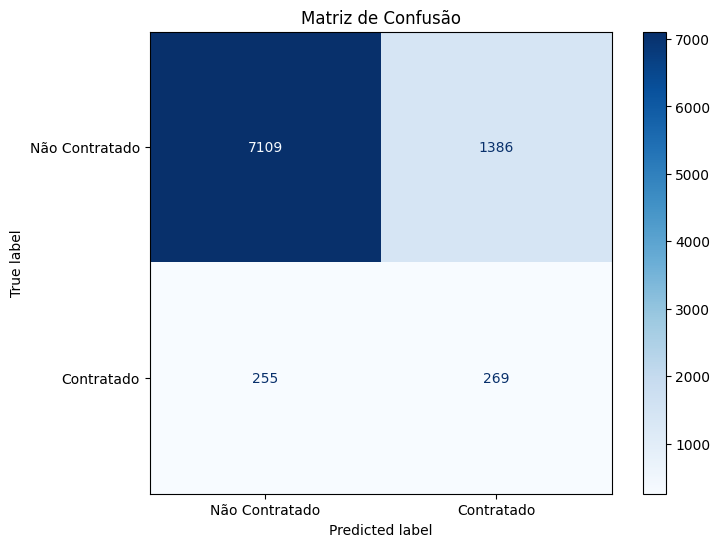

In [24]:
# --- Célula 12: Avaliação de Performance do Modelo ---

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Iniciando a avaliação do modelo no conjunto de teste...")

# 1. Fazer predições nos dados de teste
y_pred = model.predict(X_test)

# 2. Gerar o Relatório de Classificação
# Este relatório é a nossa principal ferramenta de avaliação.
print("\n--- Relatório de Classificação ---")
# target_names nos ajuda a dar nomes legíveis às classes 0 e 1.
print(classification_report(y_test, y_pred, target_names=['Não Contratado (0)', 'Contratado (1)']))

# Análise do Relatório:
# - Precision (Precisão): Dos que o modelo disse que seriam contratados, quantos realmente foram? (Evitar falsos positivos)
# - Recall (Revocação/Sensibilidade): Dos que realmente foram contratados, quantos o modelo conseguiu encontrar? (Evitar falsos negativos - nosso objetivo principal!)
# - F1-score: Média harmônica entre precisão e recall.

# 3. Gerar e Visualizar a Matriz de Confusão
# A matriz de confusão nos mostra exatamente os acertos e erros.
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Contratado', 'Contratado'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d') # 'd' para mostrar números inteiros
plt.title('Matriz de Confusão')
plt.grid(False) # Remove a grade para um visual mais limpo
plt.show()

# Análise da Matriz:
# - Canto superior esquerdo: Verdadeiros Negativos (acertou que não foi contratado)
# - Canto inferior direito: Verdadeiros Positivos (acertou que foi contratado) - QUEREMOS ESTE NÚMERO ALTO!
# - Canto superior direito: Falsos Positivos (errou, disse que seria contratado mas não foi)
# - Canto inferior esquerdo: Falsos Negativos (errou, disse que não seria contratado mas foi) - QUEREMOS ESTE NÚMERO BAIXO!

In [25]:
# --- Célula 13: Salvar o Modelo Final e os Artefatos ---

import joblib

print("Salvando o modelo treinado e a lista de colunas...")

# 1. Definir os caminhos
caminho_modelo_local = '../models/recruitment_model.joblib'
caminho_colunas_local = '../models/model_columns.joblib'
caminho_modelo_gcs = f"gs://{BUCKET_NAME}/models/recruitment_model.joblib"
caminho_colunas_gcs = f"gs://{BUCKET_NAME}/models/model_columns.joblib"

# 2. Salvar o objeto do modelo
joblib.dump(model, caminho_modelo_local)
print(f"-> Modelo salvo localmente em: {caminho_modelo_local}")

# 3. Salvar a lista de colunas que o modelo espera
# É crucial salvar isso para que a aplicação possa preparar os dados exatamente da mesma forma.
model_columns = X_train.columns
joblib.dump(model_columns, caminho_colunas_local)
print(f"-> Lista de colunas salva localmente em: {caminho_colunas_local}")

# 4. Subir os artefatos para o GCS para que a aplicação web possa acessá-los
# Usamos o objeto 'gcs' autenticado da Célula 1
with open(caminho_modelo_local, 'rb') as f:
    gcs.pipe(caminho_modelo_gcs, f.read())
print(f"-> Modelo salvo no GCS em: {caminho_modelo_gcs}")

with open(caminho_colunas_local, 'rb') as f:
    gcs.pipe(caminho_colunas_gcs, f.read())
print(f"-> Lista de colunas salva no GCS em: {caminho_colunas_gcs}")


print("\n-> Todos os artefatos do modelo foram salvos com sucesso!")

Salvando o modelo treinado e a lista de colunas...
-> Modelo salvo localmente em: ../models/recruitment_model.joblib
-> Lista de colunas salva localmente em: ../models/model_columns.joblib
-> Modelo salvo no GCS em: gs://datathon-decision-ai-bolanos/models/recruitment_model.joblib
-> Lista de colunas salva no GCS em: gs://datathon-decision-ai-bolanos/models/model_columns.joblib

-> Todos os artefatos do modelo foram salvos com sucesso!
